In [934]:
#Median Housing data from Historical Property Assessments from the City of Calgary
#New housing price index, monthly Data from Statistics Canada 
#Calgary Population Data from Macrotrends
#Median Income Data from Statistics Canada



In [935]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
import plotly.graph_objects as go
import plotly.express as px





In [936]:
#importing data
housing_data = pd.read_csv('../data/price_index.csv')
interest_rate_data = pd.read_csv('../data/canadian_interest_rates.csv')
income_data = pd.read_csv('../data/income_data.csv')
population_data = pd.read_csv('../data/calgary_population.csv')
median_house_price_data = pd.read_csv('../data/median_assessed_value.csv')


In [937]:
# Take a quick look at the data
print(housing_data.head())
print(interest_rate_data.head())
print(income_data.head())
print(population_data.head())

  REF_DATE              GEO           DGUID New housing price indexes  \
0  1981-01           Canada  2016A000011124    Total (house and land)   
1  1981-01           Canada  2016A000011124                House only   
2  1981-01           Canada  2016A000011124                 Land only   
3  1981-01  Atlantic Region      2016A00011    Total (house and land)   
4  1981-01  Atlantic Region      2016A00011                House only   

                 UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID      VECTOR  COORDINATE  \
0  Index, 201612=100     347         units          0  v111955442         1.1   
1  Index, 201612=100     347         units          0  v111955443         1.2   
2  Index, 201612=100     347         units          0  v111955444         1.3   
3  Index, 201612=100     347         units          0  v111955445         2.1   
4  Index, 201612=100     347         units          0  v111955446         2.2   

   VALUE STATUS  SYMBOL  TERMINATED  DECIMALS  
0   38.2    NaN     NaN   

In [938]:
#Viewing Columns Names
print(housing_data.columns)
print(interest_rate_data.columns)
print(income_data.columns)
print(population_data.columns)

Index(['REF_DATE', 'GEO', 'DGUID', 'New housing price indexes', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')
Index(['REF_DATE', 'GEO', 'DGUID', 'Rates', 'UOM', 'UOM_ID', 'SCALAR_FACTOR',
       'SCALAR_ID', 'VECTOR', 'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL',
       'TERMINATED', 'DECIMALS'],
      dtype='object')
Index(['REF_DATE', 'GEO', 'DGUID', 'Age group', 'Sex', 'Income source',
       'Statistics', 'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR',
       'COORDINATE', 'VALUE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS'],
      dtype='object')
Index(['date', ' Population', ' Annual Change'], dtype='object')


In [939]:
#Dropping other provinces
housing_data = housing_data[housing_data.GEO == 'Calgary, Alberta']
#Filter for "Total (house and land)" category
housing_data = housing_data[housing_data['New housing price indexes'] == 'Total (house and land)']


#Dropping unused columns, axis=1 means dropping rows, inplace=True changes the original dataframe
housing_data.drop(['DGUID', 'New housing price indexes', 'UOM',
       'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR', 'COORDINATE',
       'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS', 'GEO'], axis=1, inplace=True)


interest_rate_data.drop(['DGUID', 'Rates', 'UOM', 'UOM_ID', 'SCALAR_FACTOR',
                         'SCALAR_ID', 'VECTOR', 'COORDINATE', 'STATUS', 
                         'SYMBOL', 'TERMINATED', 'DECIMALS', 'GEO'], axis=1, inplace=True)



#Filtering data by Median Income, Better than average as high earnings skew data
income_data = income_data[income_data['Statistics'] == 'Median income (excluding zeros)']

#Dropping Unused Columns
income_data.drop(['DGUID', 'Age group', 'Sex', 'Income source',
        'UOM', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID', 'VECTOR',
       'COORDINATE', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS','Statistics', 'GEO'], axis=1, inplace=True)


In [940]:
#Converting ref_date to datetime format
housing_data.REF_DATE = pd.to_datetime(housing_data.REF_DATE)
interest_rate_data.REF_DATE = pd.to_datetime(interest_rate_data.REF_DATE)
population_data.date = pd.to_datetime(population_data.date)
income_data['REF_DATE'] = pd.to_datetime(income_data['REF_DATE'], format='%Y')





In [941]:
housing_data.set_index('REF_DATE', inplace=True)
interest_rate_data.set_index('REF_DATE', inplace=True)
income_data.set_index('REF_DATE', inplace=True)
population_data.set_index('date', inplace=True)

In [942]:
#Checking for NAN values
housing_data.isna().values.any()
interest_rate_data.isna().values.any()
income_data.isna().values.any()
population_data.isna().values.any()

True

In [943]:
#Checking for dupliactes
print(housing_data.duplicated())
print(interest_rate_data.duplicated())
print(income_data.duplicated())
print(population_data.duplicated())

REF_DATE
1981-01-01    False
1981-02-01    False
1981-03-01    False
1981-04-01    False
1981-05-01     True
              ...  
2024-04-01    False
2024-05-01    False
2024-06-01    False
2024-07-01    False
2024-08-01    False
Length: 524, dtype: bool
REF_DATE
1981-01-07    False
1981-01-14    False
1981-01-21    False
1981-01-28     True
1981-02-04    False
              ...  
2024-09-04     True
2024-09-11     True
2024-09-18     True
2024-09-25     True
2024-10-02     True
Length: 2283, dtype: bool
REF_DATE
1981-01-01    False
1982-01-01    False
1983-01-01    False
1984-01-01    False
1985-01-01    False
1986-01-01    False
1987-01-01    False
1988-01-01     True
1989-01-01    False
1990-01-01    False
1991-01-01    False
1992-01-01    False
1993-01-01    False
1994-01-01    False
1995-01-01    False
1996-01-01    False
1997-01-01    False
1998-01-01    False
1999-01-01    False
2000-01-01    False
2001-01-01    False
2002-01-01    False
2003-01-01    False
2004-01-01    False
20

In [944]:
# View the result
print(housing_data.head())
print(population_monthly.head())
print(interest_rate_monthly.head())
print(income_data.head())


            VALUE
REF_DATE         
1981-01-01   25.3
1981-02-01   25.5
1981-03-01   25.8
1981-04-01   26.7
1981-05-01   26.7
      REF_DATE   Population   Annual Change
649 2005-01-01    1030000.0            2.59
650 2005-02-01    1030000.0            2.59
651 2005-03-01    1030000.0            2.59
652 2005-04-01    1030000.0            2.59
653 2005-05-01    1030000.0            2.59
      REF_DATE  VALUE
288 2005-01-01   2.75
289 2005-02-01   2.75
290 2005-03-01   2.75
291 2005-04-01   2.75
292 2005-05-01   2.75
            VALUE
REF_DATE         
1981-01-01  45000
1982-01-01  46700
1983-01-01  39100
1984-01-01  37800
1985-01-01  42600


In [945]:
median_house_price_data = pd.read_csv('../data/median_assessed_value.csv')
median_house_price_data.rename(columns={'ROLL_YEAR': 'REF_DATE'}, inplace=True)
median_house_price_data['REF_DATE'] = pd.to_datetime(median_house_price_data['REF_DATE'], format='%Y')
median_house_price_data = median_house_price_data.set_index('REF_DATE').resample('MS').ffill()
print(median_house_price_data.head(24))  # Shows first year of monthly data


            median_re_assessed_value
REF_DATE                            
2005-01-01                    206500
2005-02-01                    206500
2005-03-01                    206500
2005-04-01                    206500
2005-05-01                    206500
2005-06-01                    206500
2005-07-01                    206500
2005-08-01                    206500
2005-09-01                    206500
2005-10-01                    206500
2005-11-01                    206500
2005-12-01                    206500
2006-01-01                    221000
2006-02-01                    221000
2006-03-01                    221000
2006-04-01                    221000
2006-05-01                    221000
2006-06-01                    221000
2006-07-01                    221000
2006-08-01                    221000
2006-09-01                    221000
2006-10-01                    221000
2006-11-01                    221000
2006-12-01                    221000


In [946]:
# Take a quick look at the data
print(housing_data.head())
print(interest_rate_data.head())
print(income_data.head())
print(population_data.head())

            VALUE
REF_DATE         
1981-01-01   25.3
1981-02-01   25.5
1981-03-01   25.8
1981-04-01   26.7
1981-05-01   26.7
            VALUE
REF_DATE         
1981-01-07  17.26
1981-01-14  17.00
1981-01-21  16.97
1981-01-28  17.00
1981-02-04  17.11
            VALUE
REF_DATE         
1981-01-01  45000
1982-01-01  46700
1983-01-01  39100
1984-01-01  37800
1985-01-01  42600
            Population  Annual Change
date                                 
1950-12-31      132000            NaN
1951-12-31      141000           6.82
1952-12-31      151000           7.09
1953-12-31      162000           7.28
1954-12-31      174000           7.41


In [947]:
#Viewing Columns Names
print(housing_data.columns)
print(interest_rate_data.columns)
print(income_data.columns)
print(population_data.columns)

Index(['VALUE'], dtype='object')
Index(['VALUE'], dtype='object')
Index(['VALUE'], dtype='object')
Index([' Population', ' Annual Change'], dtype='object')


In [948]:
#Checking for NAN values
housing_data.isna().values.any()
interest_rate_data.isna().values.any()
income_data.isna().values.any()
population_data.isna().values.any()

True

In [949]:
#Checking for dupliactes
print(housing_data.duplicated())
print(interest_rate_data.duplicated())
print(income_data.duplicated())
print(population_data.duplicated())

REF_DATE
1981-01-01    False
1981-02-01    False
1981-03-01    False
1981-04-01    False
1981-05-01     True
              ...  
2024-04-01    False
2024-05-01    False
2024-06-01    False
2024-07-01    False
2024-08-01    False
Length: 524, dtype: bool
REF_DATE
1981-01-07    False
1981-01-14    False
1981-01-21    False
1981-01-28     True
1981-02-04    False
              ...  
2024-09-04     True
2024-09-11     True
2024-09-18     True
2024-09-25     True
2024-10-02     True
Length: 2283, dtype: bool
REF_DATE
1981-01-01    False
1982-01-01    False
1983-01-01    False
1984-01-01    False
1985-01-01    False
1986-01-01    False
1987-01-01    False
1988-01-01     True
1989-01-01    False
1990-01-01    False
1991-01-01    False
1992-01-01    False
1993-01-01    False
1994-01-01    False
1995-01-01    False
1996-01-01    False
1997-01-01    False
1998-01-01    False
1999-01-01    False
2000-01-01    False
2001-01-01    False
2002-01-01    False
2003-01-01    False
2004-01-01    False
20

In [950]:
# Resample to monthly frequency using forward-fill to fill the year for each month, 'MS' is month start frequency
population_monthly = population_data.resample('MS').ffill()
interest_rate_monthly = interest_rate_data.resample('MS').mean()
income_monthly = income_data.resample('MS').ffill()  

# Reset any data beyond 2022-12-31 to NaN
income_monthly.loc['2023-01-01':, 'VALUE'] = np.nan  # Assuming 'VALUE' is the column name for income

# Limit income data to 2022 for forward fill
income_monthly = income_monthly[income_monthly.index <= '2023-12-31']


# Reset index to make 'date' a column again
population_monthly.reset_index(inplace=True)
interest_rate_monthly.reset_index(inplace=True)
income_monthly.reset_index(inplace=True)


# Rename 'date' to 'REF_DATE'
population_monthly.rename(columns={'date': 'REF_DATE'}, inplace=True)

# Ensure 'REF_DATE' is in monthly format
population_monthly['REF_DATE'] = pd.to_datetime(population_monthly['REF_DATE'])
population_monthly['REF_DATE'] = population_monthly['REF_DATE'].dt.to_period('M').dt.to_timestamp()

population_monthly.dropna(inplace=True)


# Filter population data to include only records from 2005 onwards
population_monthly = population_monthly[(population_monthly['REF_DATE'] >= '2005-01-01') & (population_monthly['REF_DATE'] <= '2024-12-31')]

# Filter other datasets similarly to match the timeframe of the median house price data
interest_rate_monthly = interest_rate_monthly[(interest_rate_monthly['REF_DATE'] >= '2005-01-01') & (interest_rate_monthly['REF_DATE'] <= '2024-12-31')]
income_monthly = income_monthly[(income_monthly['REF_DATE'] >= '2005-01-01') & (income_monthly['REF_DATE'] <= '2024-12-31')]
housing_data = housing_data[(housing_data.index >= '2005-01-01') & (housing_data.index <= '2024-12-31')]
median_house_price_data = median_house_price_data[(median_house_price_data.index >= '2005-01-01') & (median_house_price_data.index <= '2024-12-31')]


In [951]:
income_monthly.tail()

,REF_DATE,VALUE
488,2021-09-01,43400
489,2021-10-01,43400
490,2021-11-01,43400
491,2021-12-01,43400
492,2022-01-01,48000


In [952]:
# View the result
print(housing_data.head())
print(population_monthly.head())
print(interest_rate_monthly.head())
print(income_monthly.head())


            VALUE
REF_DATE         
2005-01-01   52.0
2005-02-01   52.3
2005-03-01   52.4
2005-04-01   52.8
2005-05-01   53.1
      REF_DATE   Population   Annual Change
649 2005-01-01    1030000.0            2.59
650 2005-02-01    1030000.0            2.59
651 2005-03-01    1030000.0            2.59
652 2005-04-01    1030000.0            2.59
653 2005-05-01    1030000.0            2.59
      REF_DATE  VALUE
288 2005-01-01   2.75
289 2005-02-01   2.75
290 2005-03-01   2.75
291 2005-04-01   2.75
292 2005-05-01   2.75
      REF_DATE  VALUE
288 2005-01-01  43100
289 2005-02-01  43100
290 2005-03-01  43100
291 2005-04-01  43100
292 2005-05-01  43100


In [953]:

# Now merge the filtered datasets
merged_data = housing_data.merge(interest_rate_monthly, on='REF_DATE', how='left', suffixes=('_housing', '_interest'))
merged_data = merged_data.merge(income_monthly, on='REF_DATE', how='left')
merged_data = merged_data.merge(population_monthly, on='REF_DATE', how='left')
merged_data = merged_data.merge(median_house_price_data, on='REF_DATE', how='left')

# Forward fill missing values for Median_House_Price after 2005
merged_data['median_re_assessed_value'] = merged_data['median_re_assessed_value'].ffill()


merged_data.set_index('REF_DATE', inplace=True)

In [954]:
# Renaming columns for more clarity
merged_data.rename(columns={
    'VALUE_housing': 'Housing_Price_Index',
    'VALUE_interest': 'Interest_Rate',
    'VALUE': 'Median_Income',
    ' Population': 'Calgary_Population',
    ' Annual Change': 'Annual_Population_Change',
    'median_re_assessed_value': 'Median_House_Price'
}, inplace=True)


# View the updated DataFrame
print(merged_data.head())

print(merged_data.tail())


            Housing_Price_Index  Interest_Rate  Median_Income  \
REF_DATE                                                        
2005-01-01                 52.0           2.75        43100.0   
2005-02-01                 52.3           2.75        43100.0   
2005-03-01                 52.4           2.75        43100.0   
2005-04-01                 52.8           2.75        43100.0   
2005-05-01                 53.1           2.75        43100.0   

            Calgary_Population  Annual_Population_Change  Median_House_Price  
REF_DATE                                                                      
2005-01-01           1030000.0                      2.59            206500.0  
2005-02-01           1030000.0                      2.59            206500.0  
2005-03-01           1030000.0                      2.59            206500.0  
2005-04-01           1030000.0                      2.59            206500.0  
2005-05-01           1030000.0                      2.59            20

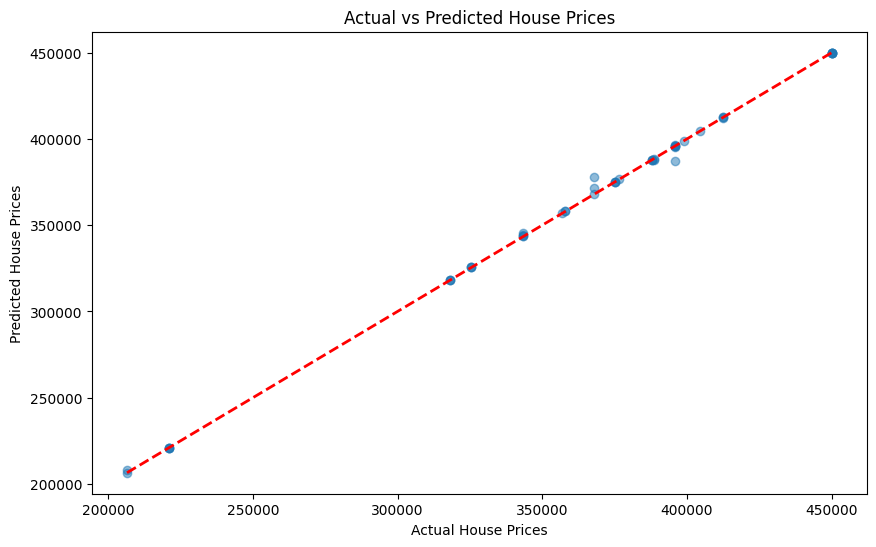

In [955]:

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual House Prices')
plt.ylabel('Predicted House Prices')
plt.title('Actual vs Predicted House Prices')
plt.show()


In [956]:
# Ensure merged_data only contains data from 2005 onwards
merged_data = merged_data[merged_data.index >= '2005-01-01']

# Define features (X) and target (y)
X = merged_data[['Housing_Price_Index', 'Interest_Rate', 'Median_Income', 'Calgary_Population', 'Annual_Population_Change']]  # Features
y = merged_data['Median_House_Price']  # Target (what you are predicting)

# Handle NaNs (e.g., filling with the mean)
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 4120292.7083333335
R-squared: 0.999047188504059


/var/folders/c8/wgg214m53kj69jc41gfrvs3w0000gn/T/ipykernel_12865/2137424354.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [957]:
# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame to organize feature importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Sort by importance (descending)
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display the feature importances
print(feature_importances)


                    Feature  Importance
3        Calgary_Population    0.746719
2             Median_Income    0.096204
0       Housing_Price_Index    0.084552
4  Annual_Population_Change    0.049649
1             Interest_Rate    0.022876


In [958]:
# Step 1: Create Future Dataset (2025–2030)
# Creating a future date range for monthly data from 2025 to 2030
future_dates = pd.date_range(start='2025-01-01', end='2030-12-01', freq='MS')

# Create a DataFrame for future data
future_data = pd.DataFrame(future_dates, columns=['REF_DATE'])

# Project future values for each feature (use linear projections or assumptions)
future_data['Housing_Price_Index'] = np.linspace(merged_data['Housing_Price_Index'].iloc[-1], merged_data['Housing_Price_Index'].iloc[-1] * 1.05, len(future_dates))
future_data['Interest_Rate'] = np.linspace(merged_data['Interest_Rate'].iloc[-1], merged_data['Interest_Rate'].iloc[-1] - 0.5, len(future_dates))  # Assume a slight drop
future_data['Median_Income'] = np.linspace(merged_data['Median_Income'].iloc[-1], merged_data['Median_Income'].iloc[-1] * 1.1, len(future_dates))  # Assume income growth
future_data['Calgary_Population'] = np.linspace(merged_data['Calgary_Population'].iloc[-1], merged_data['Calgary_Population'].iloc[-1] * 1.1, len(future_dates))  # Assume population growth
future_data['Annual_Population_Change'] = np.linspace(merged_data['Annual_Population_Change'].iloc[-1], merged_data['Annual_Population_Change'].iloc[-1], len(future_dates))  # Keep constant

# Step 2: Predict Future House Prices Using Trained Model
# Extract the features from the future data
X_future = future_data[['Housing_Price_Index', 'Interest_Rate', 'Median_Income', 'Calgary_Population', 'Annual_Population_Change']]

# Predict future house prices
future_data['Predicted_Median_House_Price'] = rf_model.predict(X_future)

# Step 3: Plot Historical and Predicted House Prices
import plotly.graph_objects as go

# Create a new line chart with historical and future predictions
fig = go.Figure()

# Plot historical median house prices
fig.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Median_House_Price'],
                         mode='lines', name='Historical Median House Price'))

# Plot future predicted house prices
fig.add_trace(go.Scatter(x=future_data['REF_DATE'], y=future_data['Predicted_Median_House_Price'],
                         mode='lines', name='Predicted Median House Price', line=dict(dash='dash')))

# Customize the layout
fig.update_layout(
    title='Historical and Predicted Median House Prices (2025-2030)',
    xaxis_title='Year',
    yaxis_title='House Prices',
    hovermode='x unified',
    width=500,  # Adjust width to fit the layout
    height=400,  # Adjust height to fit the layout
    margin=dict(l=50, r=50, t=50, b=50),  # Add margins for clarity
    title_font=dict(size=10),  # Increase title font size
    legend=dict(font=dict(size=8))  # Increase legend font size
)

# Show the plot
fig.show()

fig.write_html("predicted.html")



In [959]:
# Create a DataFrame showing feature importance over time (this is hypothetical for demo purposes)
feature_importance_over_time = pd.DataFrame({
    'Date': future_dates,
    'Interest_Rate': np.random.uniform(0.2, 0.5, len(future_dates)),
    'Median_Income': np.random.uniform(0.3, 0.6, len(future_dates)),
    'Calgary_Population': np.random.uniform(0.5, 0.8, len(future_dates)),
})

# Melt the DataFrame to long format for plotting
melted_importance = feature_importance_over_time.melt(id_vars=['Date'], var_name='Feature', value_name='Importance')

# Create the line chart
fig = px.line(melted_importance, x='Date', y='Importance', color='Feature',
              title="Feature Importance Over Time",
              labels={'Importance': 'Feature Importance', 'Date': 'Future Dates'})


# Customize the layout
fig.update_layout(
    title="Feature Importance Over Time",
    xaxis_title="Future Dates",
    yaxis_title="Feature Importance",
    hovermode='x unified',
    width=900,  # Adjust width to fit your layout
    height=400,  # Adjust height to fit your layout
    margin=dict(l=50, r=50, t=50, b=50),  # Set margins to avoid cutting off the edges
)

fig.show()

fig.write_html("feature_importance.html")

In [960]:
# Ensure data is filtered to 2005 and onwards
merged_data = merged_data[merged_data.index >= '2005-01-01']

# Create the line chart
fig = go.Figure()

# Add a trace for Median House Price
fig.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Median_House_Price'],
                         mode='lines', name='Median House Price'))

# Add a trace for Interest Rate on secondary y-axis
fig.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Interest_Rate'],
                         mode='lines', name='Interest Rate', yaxis="y2"))

# Add a trace for Calgary Population
fig.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Calgary_Population'],
                         mode='lines', name='Calgary Population'))

# Add a trace for Median Income only up to 2022
fig.add_trace(go.Scatter(x=merged_data.index, y=merged_data['Median_Income'],
                         mode='lines', name='Median Income (2005-2022)',
                         line=dict(dash='dash')))  # Dashed line to indicate partial data

# Customize the layout for two graphs on the same row, each under 500px width
fig.update_layout(
    title='Housing Prices, Interest Rates, Population, and Income (2005-2022)',
    xaxis_title='Year',
    yaxis_title='Values',
    yaxis2=dict(title="Interest Rate", overlaying='y', side='right'),  # Secondary y-axis for interest rates
    hovermode='x unified',  # Unified hover for all lines
    width=500,  # Keep the width the same
    height=500,  # Increase the height for better visibility
    margin=dict(l=50, r=50, t=50, b=50),  # Set margins to avoid cutting edges
    title_font=dict(size=11),  # Increase title font size
    xaxis=dict(tickfont=dict(size=12)),  # Increase x-axis label font size
    yaxis=dict(tickfont=dict(size=12)),  # Increase y-axis label font size
    legend=dict(font=dict(size=8))  # Increase legend font size
)


# Show the chart
fig.show()

fig.write_html("data.html")